In [1]:
import time
# Imports Gunnerus model
from torch_core.simulator.vessels.csad_torch import CSAD_6DOF


# Imports waves
from torch_core.simulator.waves.wave_load_torch import WaveLoad
from torch_core.simulator.waves.wave_spectra_torch import JONSWAP

# Imports utilities
import numpy as np
import math
import torch
import matplotlib.pyplot as plt

In [2]:
start = time.time()

dt = 0.01
simtime = 100
t = torch.arange(0, simtime, dt)

vessel = CSAD_6DOF(dt=dt, method='RK4')
print(f"Init boat took {time.time() - start:.2f} seconds")

eta = torch.zeros((6, len(t)))
nu = torch.zeros((6, len(t)))
wave_load = torch.zeros((6, len(t)))

Init boat took 0.17 seconds


In [3]:
Uc = 0.0
beta_c = 0

start = time.time()
hs = 5.0/90 # Significant wave height
tp = 9.0*np.sqrt(1/90) # Peak period
gamma = 3.3 # Peak factor
N = 100 

# Discretize freq range
wp = 2.*np.pi / tp
wmin, wmax = wp/2., 3.*wp
dw = (wmax - wmin)/N
w = np.linspace(wmin, wmax, N)


# JONSWAP in PyTorch
jonswap = JONSWAP(w)
freq, spec = jonswap(hs, tp, gamma)  # freq, spec both Tensors

wave_amps = np.sqrt(2.0 * spec.detach().cpu().numpy() * dw)
eps = np.random.uniform(0,2*np.pi, size=N)
wave_dir = np.ones(N) * math.pi/4.0  # Direction of the waves

# DiffWaveLoad expects wave_amps, freqs, eps, angles as NumPy or Torch Tensors
waveload = WaveLoad(
    wave_amps,
    freq.detach().cpu().numpy(),
    eps,
    wave_dir,
    config_file=vessel._config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=True
)
print(f"Init the everything related to the waves took {time.time() - start:.2f} seconds")

Init the everything related to the waves took 0.46 seconds


In [6]:
eta_init = torch.zeros(6)
nu_init = torch.zeros(6)


vessel.set_eta(eta_init)
vessel.set_nu(nu_init)

print("Starting simulation")
start = time.time()
tau_control = torch.tensor([0, 0, 0, 0, 0, 0], dtype=torch.float32)
for i in range(len(t)):
    tau_wave = waveload(t[i], vessel.get_eta())
    # Not ideal, but it works, but compiles slower than Numpy
    tau_wave_np = tau_wave.detach().cpu().numpy()
    tau_control_np = tau_control.detach().cpu().numpy()
    tau = tau_control_np + tau_wave_np
    eta[:, i] = vessel.get_eta()
    nu[:, i] = vessel.get_nu()
    wave_load[:, i] = tau_wave
    tau = torch.tensor(tau, dtype=torch.float32)
    vessel.integrate(Uc, beta_c, tau)


print(f"Simulation took {time.time() - start:.2f} seconds")
print(f"Simtime/Real: {simtime / (time.time() - start):.2f}")

Starting simulation
Simulation took 141.02 seconds
Simtime/Real: 0.71


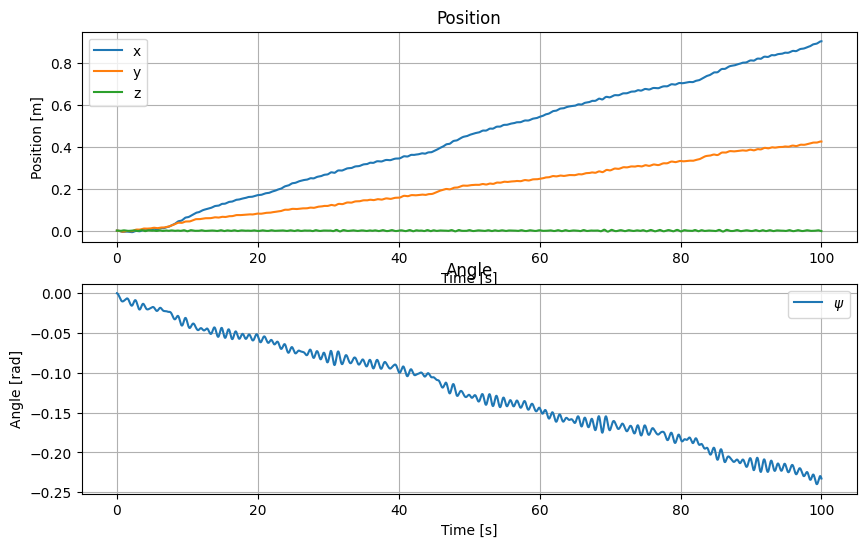

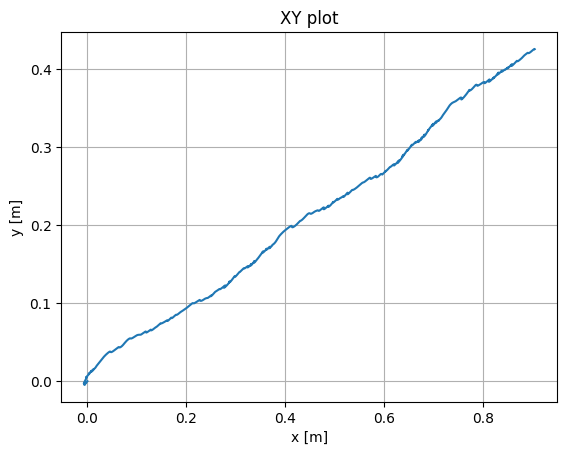

In [7]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(t, eta[0, :], label='x')
axes[0].plot(t, eta[1, :], label='y')
axes[0].plot(t, eta[2, :], label='z')
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Position [m]')
axes[0].set_title('Position')

axes[1].plot(t, eta[5, :], label=r"$\psi$")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [rad]')
axes[1].set_title('Angle')

plt.show()


# Plot XY plot to position
plt.figure()
plt.plot(eta[0, :], eta[1, :])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY plot')
plt.show()



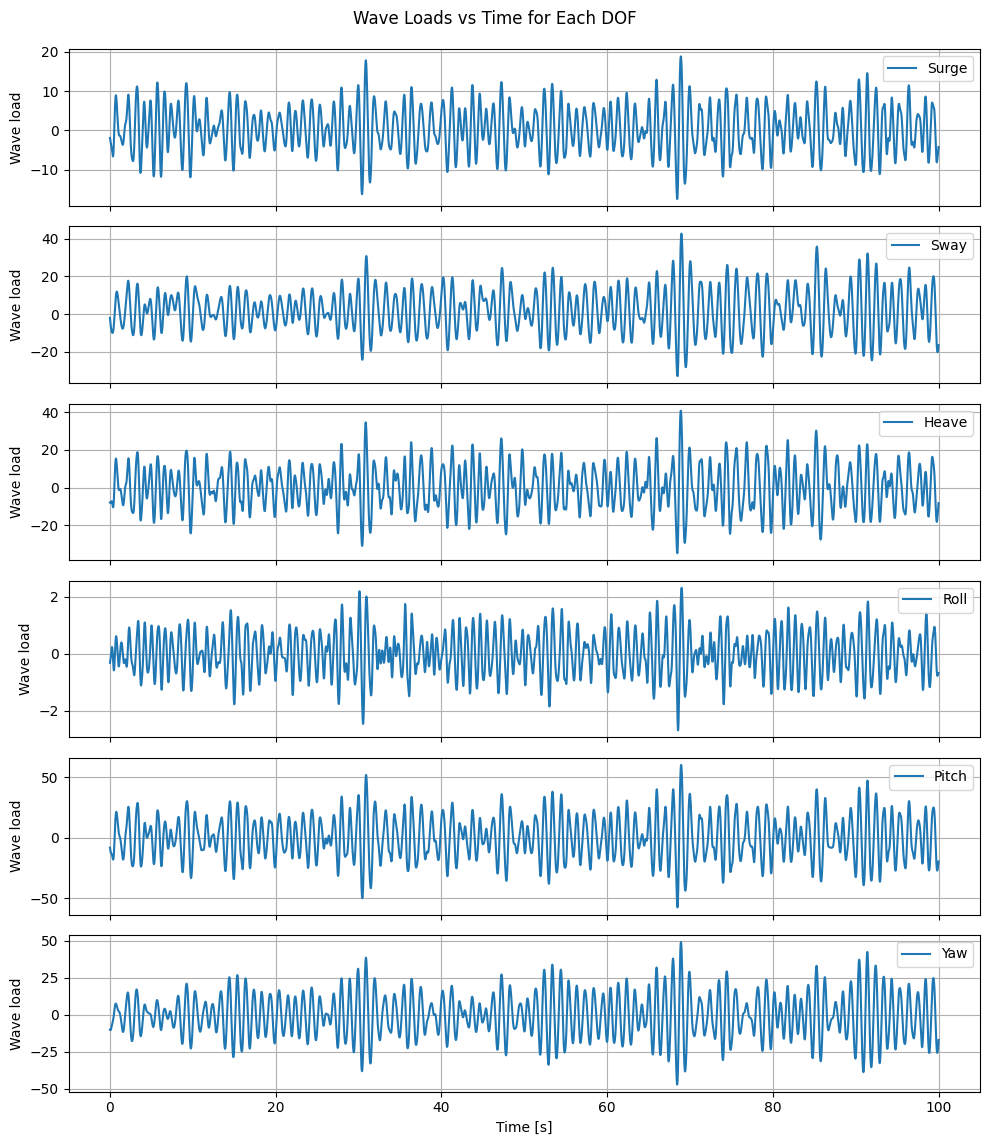

In [8]:
# ----------------------------------------------------------------------------
# Plot the wave loads vs time for each degree of freedom (DOF)
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 12), sharex=True)
dof_labels = ['Surge', 'Sway', 'Heave', 'Roll', 'Pitch', 'Yaw']

for i in range(6):
    axes[i].plot(t, wave_load[i, :], label=f'{dof_labels[i]}')
    axes[i].set_ylabel('Wave load')
    axes[i].legend()
    axes[i].grid()

axes[-1].set_xlabel('Time [s]')
fig.suptitle('Wave Loads vs Time for Each DOF', y=0.95)  # Adjusted y position
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()